In [1]:
from torchfunction.device import AutoDevice as device
from torchfunction.utils import tonumpy as tn
import torch
from matplotlib import pyplot as plt
import tqdm
from tqdm import trange, tqdm
import matplotlib as mpl
import torch.nn as nn
import math
import scipy
import numpy as np
import scipy.stats as stats
from dataset import get_standard_spike_input

from zytlib import path, table, vector

import matplotlib as mpl
dcolor = mpl.rcParams["axes.prop_cycle"].by_key()['color']
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

torch.set_printoptions(precision=2, sci_mode=False, linewidth=140, profile="short")
%config InlineBackend.figure_format = "retina"

mod_color = ['#5B6564', '#4A65B5']

[0.04989142857142857, 0.055785714285714286, 0.2347942857142857, 0.06773428571428572, 0.06714, 0.055388571428571426, 0.08033142857142857, 0.05426857142857143]
Using GPU device 5...


In [2]:
from model import lowrank_encoder, reparameter_encoder
from dataset import get_spike_input

In [3]:
def save_figure(name, path=None, dpi=300, format="jpg"):
    if isinstance(format, (list, tuple)):
        for f in format:
            save_figure(name, path=path, dpi=dpi, format=f)
        return
    if path is None:
        plt.savefig(figure_path / "{}.{}".format(name, format), format=format, dpi=dpi)
    else:
        p = (figure_path / path).mkdir()
        plt.savefig(p / "{}.{}".format(name, format), format=format, dpi=dpi)
figure_path = path("figure/rank-3-3pop/").mkdir()

In [4]:
class modified_encoder(reparameter_encoder):
    def C(self):
        C = self._C.clone()
        C[2, 9, 3] = C[1, 9, 2]
        C[2, 9, 4] = C[1, 9, 4]
        return C

In [5]:
@torch.no_grad()
def get_gain_from_rnn(rnn):
    rnn.pre_forward()
    gain = (1 - rnn.phi(rnn._I + 0*torch.randn_like(rnn._I) * rnn.hyper.noise_rec)[:, :, 2:].pow(2)).mean(1).T.detach()
    return gain

def np_str(v, p=3):
    if isinstance(v, float):
        return eval("f'{v:." + str(p) + "g}'")
    return [eval("f'{x:." + str(p) + "g}'") for x in tn(v)]


In [6]:
rnn = torch.load("rank-3-pop-3.pt")["rnn"].to(device)

In [7]:
# rnn.C(), rnn.means()

In [8]:
@torch.no_grad()
def get_acc(rnn, repeat=100):
    acc = list()
    prob_right = list()
    for r in range(repeat):
        spike_input, y, cnds, ctx, cnd_ctx = get_standard_spike_input()
        h = rnn(spike_input.to(device), noise_inp=0)
        f = rnn.phi(h)
        output = rnn.outputs(f)
        acc.append(((output[:, -1, :] * y[:, -1, :]) > 0).float())
        prob_right.append((output[:, -1, :] > 0).float())
    return torch.cat(acc, 1), torch.cat(prob_right, 1)


In [9]:
acc = list()
prob_right = list()
for l in (tbar:=trange(100)):
    rnn.resample(whiten=True)
    a, p = get_acc(rnn)
    acc.append(a.mean(1))
    prob_right.append(p.mean(1))
    tbar.set_postfix({"acc": a.mean().item()})
acc = torch.stack(acc, 0)
prob_right = torch.stack(prob_right, 0)

100%|██████████| 100/100 [05:48<00:00,  3.48s/it, acc=0.969]


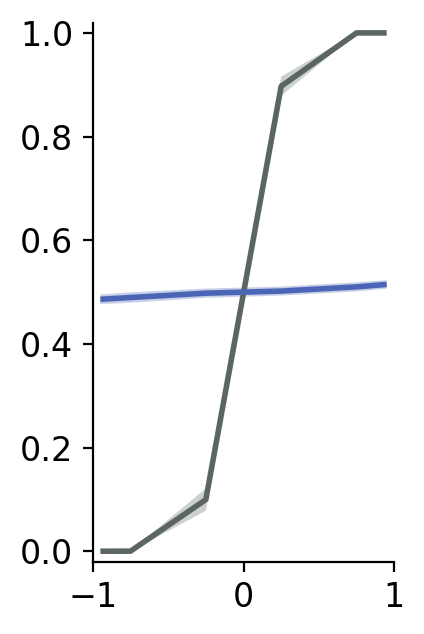

In [10]:
# Figure 3B, left

fig, ax = plt.subplots(figsize=(3.5/1.8, 3.5))

pr = prob_right.reshape(-1, 2, 6, 6)

for c in range(2):
    mean_pr = pr[:, c].mean(2).mean(0)
    std_pr = pr[:, c].mean(2).std(0)
    ax.plot(tn([-38, -30, -10, 10, 30, 38]) / 40, tn(1 - mean_pr), color=mod_color[c], lw=2, solid_capstyle="butt")
    ax.fill_between(tn([-38, -30, -10, 10, 30, 38]) / 40, tn(1 - mean_pr - std_pr), tn(1 - mean_pr + std_pr),
                   color=mod_color[c], alpha=0.3, edgecolor="none")
    
ax.spines[["top", "right"]].set_visible(False)
ax.set_xlim(-1, 1)
ax.set_ylim(-0.02, 1.02)

ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)

save_figure("prob right motion low", format="pdf")

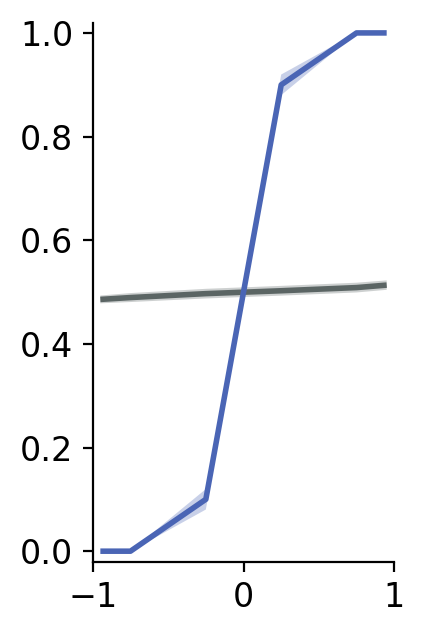

In [11]:
# Figure 3B, right

fig, ax = plt.subplots(figsize=(3.5/1.8, 3.5))

pr = prob_right.reshape(-1, 2, 6, 6)

for c in range(2):
    mean_pr = pr[:, c].mean(1).mean(0)
    std_pr = pr[:, c].mean(1).std(0)
    ax.plot(tn([-38, -30, -10, 10, 30, 38]) / 40, tn(1 - mean_pr), color=mod_color[c], lw=2, solid_capstyle="butt")
    ax.fill_between(tn([-38, -30, -10, 10, 30, 38]) / 40, tn(1 - mean_pr - std_pr), tn(1 - mean_pr + std_pr),
                   color=mod_color[c], alpha=0.3, edgecolor="none")
    
ax.spines[["top", "right"]].set_visible(False)
ax.set_xlim(-1, 1)
ax.set_ylim(-0.02, 1.02)

ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)

save_figure("prob right loc low", format="pdf")

In [12]:
def power_method_batch_lowrank(U, V, num_iterations=1000, tolerance=1e-6):
    if U.dim() == 3:
        batch_size, n, _ = U.shape
        V_T = V.permute([0, 2, 1])
        # Initialize a random vector for each batch
        b_k = torch.rand((batch_size, n), dtype=U.dtype, device=U.device)
        b_k = b_k / torch.norm(b_k, dim=1, keepdim=True)  # Normalize

        for _ in range(num_iterations):
            # Compute A * b_k for each batch
            b_k1 = torch.bmm(U, torch.bmm(V_T / n, b_k.unsqueeze(-1))).squeeze(-1)
            # Normalize
            b_k1_norm = torch.norm(b_k1, dim=1, keepdim=True)
            b_k1 = b_k1 / b_k1_norm
            # Check for convergence
            if torch.norm(b_k1 - b_k) < tolerance:
                break
            b_k = b_k1

        # Compute the corresponding eigenvalues
        eigenvalues = torch.bmm(b_k.unsqueeze(1), torch.bmm(U, torch.bmm(V_T, b_k.unsqueeze(-1)))).squeeze(-1).squeeze(-1) / n
        # Ensure the eigenvector is normalized
        eigenvalues = eigenvalues / torch.sum(b_k**2, dim=1)
        return eigenvalues, b_k
    else:
        U = U.unsqueeze(0)
        V = V.unsqueeze(0)
        e, b = power_method_batch_lowrank(U, V, num_iterations=num_iterations, tolerance=tolerance)
        return e[0], b[0, :]

In [13]:
def print_dict_shapes(data, indent=''):
    for key, value in data.items():
        if isinstance(value, dict):
            print(f"{indent}{key}:")
            print_dict_shapes(value, indent + '\t')
        elif isinstance(value, list):
            print(f"{indent}{key}: list of length {len(value)}")
            if value:
                print(f"{indent}\tFirst element:")
                temp_data = {'First element': value[0]}
                print_dict_shapes(temp_data, indent + '\t')
        else:
            print(f"{indent}{key}: {getattr(value, 'shape', 'Not an array or tensor')}")
            
def cosine_similarity(vector_a, vector_b):
    # Compute the dot product
    dot_product = torch.dot(vector_a, vector_b)

    # Compute the magnitudes (L2 norms)
    magnitude_a = torch.norm(vector_a)
    magnitude_b = torch.norm(vector_b)

    # Handle the corner case where the magnitude of either vector is zero
    if magnitude_a == 0 or magnitude_b == 0:
        raise ValueError("One or both of the vectors have zero magnitude, cannot compute cosine similarity.")

    # Compute the cosine of the angle between the vectors
    cosine_angle = dot_product / (magnitude_a * magnitude_b)

    return cosine_angle.item()

def covariance(x, y):
    x = x - x.mean()
    y = y - y.mean()
    return (x * y).sum()

In [14]:
# List to store results from each iteration
all_result = list()
# Loop over 100 random RNN resamplings
for r in (tbar:=trange(100)):
    result_dict = dict()
    with torch.no_grad():
        # Resample RNN weights with whitening
        rnn.resample(whiten=True)
        # Initialize storage for singular vectors, input modulations, etc.
        sv = [None, None]
        I = [[None, None], [None, None]]
        choice = [None, None]
        gain = [None, None]
        # Reshape RNN parameters for later use
        rnn_U = rnn._U.reshape(-1, rnn.hyper.max_rank)
        rnn_V = rnn._V.reshape(-1, rnn.hyper.max_rank)
        rnn_I = rnn._I.reshape(-1, rnn.hyper.input_dim)
        # Generate input data for the RNN
        spike_input, y, mask, cnds, ctx, cnd_ctx = get_spike_input(256, fixed_t=10)
        # Run the RNN to get hidden states
        h = rnn(spike_input.to(device), noise_inp=0)
#         print(h.shape)
        # Loop over both contexts (0 and 1)
        for c in [0, 1]:
            # Select hidden states for current context and time window, take first 10 trials
            h1 = h[ctx == c, 10:20, :][:10].clone()
            # Flatten to (trials*time, hidden_dim)
            x = h1.view(-1, h1.shape[-1]).detach().clone()
            with torch.enable_grad():
                x.requires_grad_()
                # Optimize to find slow points (fixed points) in the RNN dynamics
                slow_point_optim = torch.optim.Adam([x], lr=1e-2)
                ctx_vector = [[0.0, 0, 1, 0], [0.0, 0, 0, 1]][c]
                for k in range(75):
                    slow_point_optim.zero_grad()
                    # Compute velocity of RNN state under current context
                    v = rnn.velocity(x, torch.tensor(ctx_vector).to(device).view(1, 4).repeat(x.shape[0], 1))
                    # Squared velocity (energy)
                    q = v.pow(2).sum(-1) * 0.5
                    loss = q.mean()
                    (loss).backward()
                    slow_point_optim.step()
            # Select slow points (where velocity is small)
            K = x[q < 1, :].shape[0]
            x1 = x[q < 1, :]
            # Compute gain for each slow point
            gain1 = (1 - torch.tanh(x1).pow(2))
            # Compute context-dependent U matrix (gain-modulated)
            rnn_GainedU = torch.einsum("bn,nr->bnr", gain1, rnn_U)
            # Repeat V for batch
            rnn_GainedV = rnn_V.unsqueeze(0).repeat(gain1.shape[0], 1, 1)
            # Compute singular values for each slow point
            S = power_method_batch_lowrank(rnn_GainedU, rnn_GainedV)[0]
            # Find the slow point with singular value closest to 1
            i = (S-1).pow(2).min(dim=0).indices.item()
#             print(S[i])

            # Use the selected slow point
            x1 = x[q < 1, :][i]
            gain1 = (1 - torch.tanh(x1).pow(2))
            # Gain-modulate U for this slow point
            rnn_GainedU = torch.einsum("i,ir->ir", gain1, rnn_U)
            # Compute right singular vector (sv) for this context
            S, V = power_method_batch_lowrank(rnn_V, rnn_GainedU)
            sv[c] = V
            # Compute gain-modulated input weights for both input channels
            I[0][c] = gain1 * rnn_I[:, 0]
            I[1][c] = gain1 * rnn_I[:, 1]

            # Compute left singular vector (choice) for this context
            S, V = power_method_batch_lowrank(rnn_GainedU, rnn_V)
            choice[c] = V
            gain[c] = gain1
        # Align the signs of the singular vectors and choice vectors for consistency
        if (sv[0] * I[0][0]).sum() < 0:
            sv[0] = -sv[0]
        if (choice[0] * sv[0]).sum() < 0:
            choice[0] = -choice[0]
        if (choice[1] * choice[0]).sum() < 0:
            choice[1] = -choice[1]
        if (sv[1] * choice[1]).sum() < 0:
            sv[1] = -sv[1]
        # Normalize singular vectors so that their dot product with choice is 1
        for r in range(2):
            sv[r] = sv[r] / (sv[r] * choice[r]).sum()
        # Compute input modulation, selection modulation, and their proportions
        inp_mod = [None, None]
        sel_mod = [None, None]
        tot_mod = [None, None]
        inp_mod_prop = [None, None]
        sel_mod_prop = [None, None]
        for r in range(2):
            rel_ctx = r
            irrel_ctx = 1 - r
            # Input modulation: difference in input weights projected onto sum of singular vectors
            inp_mod[r] = ((I[r][rel_ctx] - I[r][irrel_ctx]) * (sv[rel_ctx] + sv[irrel_ctx]) / 2).sum().item()
            # Selection modulation: sum of input weights projected onto difference of singular vectors
            sel_mod[r] = ((I[r][rel_ctx] + I[r][irrel_ctx]) / 2 * (sv[rel_ctx] - sv[irrel_ctx])).sum().item()
            tot_mod[r] = inp_mod[r] + sel_mod[r]
            inp_mod_prop[r] = inp_mod[r] / tot_mod[r]
            sel_mod_prop[r] = sel_mod[r] / tot_mod[r]
    # Store all computed quantities in the result dictionary
    result_dict["sv"] = sv
    result_dict["I"] = I
    result_dict["choice"] = choice
    result_dict["gain"] = gain
    result_dict["rnn_U"] = rnn_U
    result_dict["rnn_V"] = rnn_V
    result_dict["rnn_I"] = rnn_I
    result_dict["inp_mod"] = inp_mod
    result_dict["sel_mod"] = sel_mod
    result_dict["tot_mod"] = tot_mod
    result_dict["inp_mod_prop"] = inp_mod_prop
    result_dict["sel_mod_prop"] = sel_mod_prop
    # Show cosine similarity between singular vectors in progress bar
    tbar.set_postfix({"sv": cosine_similarity(sv[rel_ctx], sv[irrel_ctx])})
    # Append result to the list
    all_result.append(result_dict)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:33<00:00,  3.01it/s, sv=0.724]


In [15]:
sim_sv = list()
sim_I = torch.zeros(len(all_result), 2)
sim_sv_I = torch.zeros(len(all_result), 2, 2)
sim_sv_choice = torch.zeros(len(all_result), 2)
for i, l in enumerate(all_result):
    sim_sv.append(cosine_similarity(l["sv"][0], l["sv"][1]))
    for r in range(2):
        sim_I[i, r] = cosine_similarity(l["I"][r][0], l["I"][r][1])
    for r in range(2):
        for c in range(2):
            sim_sv_I[i, r, c] = cosine_similarity(l["sv"][c], l["I"][r][c])
    for c in range(2):
        sim_sv_choice[i, c] = cosine_similarity(l["sv"][c], l["choice"][c])

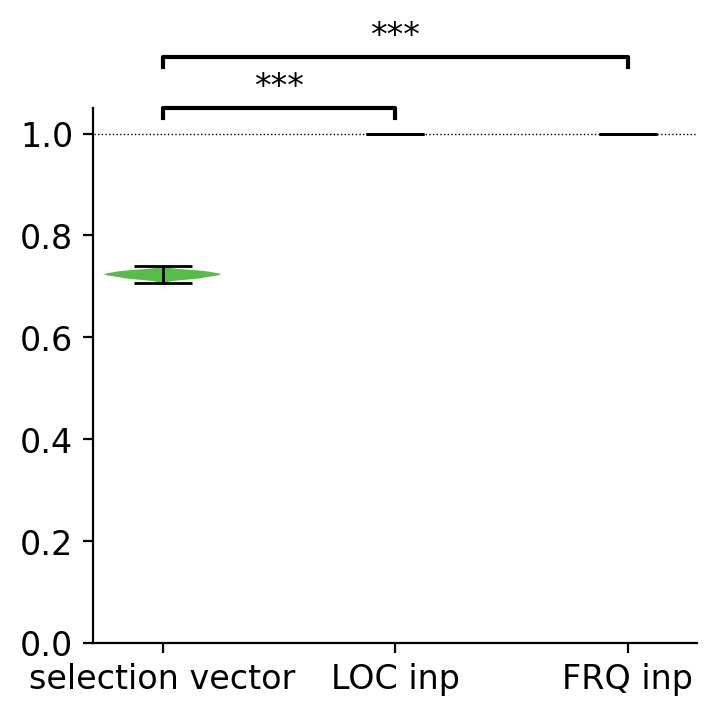

In [16]:
# Figure 3C

fig, ax = plt.subplots(figsize=(3.9, 3.9))

parts = ax.violinplot([sim_sv, sim_I[:, 0], sim_I[:, 1]])

for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor((["#57BD49"] + mod_color)[i])
    pc.set_edgecolor('none')
    pc.set_alpha(1)
    
# Set line color to black
for key in ['cmeans', 'cmins', 'cmaxes', 'cbars']:
    if key in parts:
        parts[key].set_edgecolor('black')
        parts[key].set_linewidth(1.)  # Set line width thicker if needed

# ax.set_ylim(-0.0, 1.01)
ax.spines[["right", "top"]].set_visible(False)
ax.set_xticks([1,2,3])
ax.plot([0.5, 3.5], [1,1], "k:", lw=0.5)
ax.set_xlim(0.7, 3.3)

# Position and offset settings
y_max = 1.03
height = 0.02
line_width = 1.5
text_offset = 0.01

# Add significance markers and brackets
# Between 1 and 2
x1, x2 = 1, 2
y, h, col = y_max, height, 'k'
ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=line_width, c=col)
ax.text((x1 + x2) * .5, y + h + text_offset, "***", ha='center', va='bottom', color=col, fontsize=12)

# Between 1 and 3
x1, x2 = 1, 3
y, h, col = y_max + 0.1, height, 'k'  # y increased by 0.1 to avoid overlap
ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=line_width, c=col)
ax.text((x1 + x2) * .5, y + h + text_offset, "***", ha='center', va='bottom', color=col, fontsize=12)

# Set axis display range, shorten axis length
ax.spines['left'].set_bounds(0, 1.05)  # Limit y-axis display range

# Adjust y-axis ticks and labels
ax.set_ylim(0, 1.18)  # Allow significance markers to be shown outside axis
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])

ax.set_xticklabels(["selection vector", "LOC inp", "FRQ inp"])
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)

save_figure("cos angle between ctx", format="pdf")

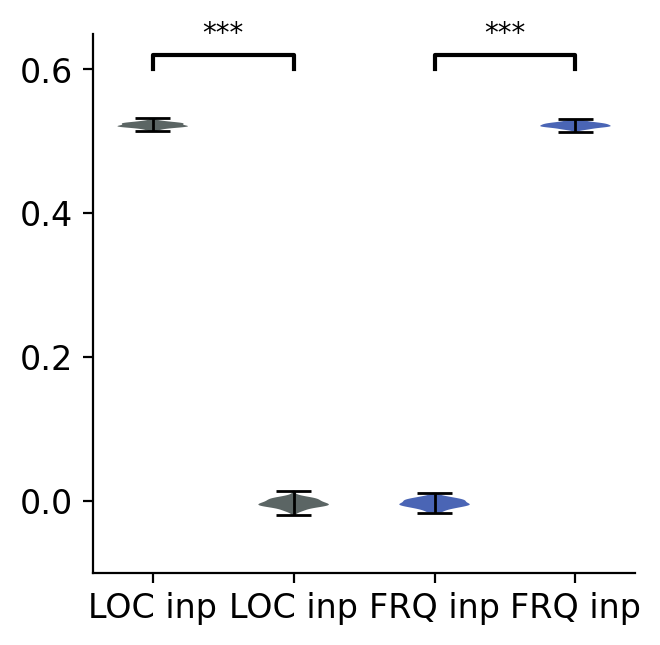

In [17]:
# Figure 3D

fig, ax = plt.subplots(figsize=(3.5, 3.5))

parts = ax.violinplot([sim_sv_I[:, 0, 0], sim_sv_I[:, 0, 1], sim_sv_I[:, 1, 0], sim_sv_I[:, 1, 1]])

for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(mod_color[i//2])
    pc.set_edgecolor('none')
    pc.set_alpha(1)

# Set line color to black
for key in ['cmeans', 'cmins', 'cmaxes', 'cbars']:
    if key in parts:
        parts[key].set_edgecolor('black')
        parts[key].set_linewidth(1.)  # Set line width thicker if needed

# ax.set_ylim(-0.0, 1.01)
ax.spines[["right", "top"]].set_visible(False)
# ax.set_xticks([1,2,3])
# ax.plot([0.5, 3.5], [1,1], "k:", lw=0.5)
# ax.set_xlim(0.7, 3.3)

# Position and offset settings
y_max = 0.6
height = 0.02
line_width = 1.5
text_offset = 0.01

# Add significance markers and brackets
# Between 1 and 2
x1, x2 = 1, 2
y, h, col = y_max, height, 'k'
ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=line_width, c=col)
ax.text((x1 + x2) * .5, y + h + text_offset, "***", ha='center', va='bottom', color=col)

# Between 3 and 4
x1, x2 = 3, 4
y, h, col = y_max, height, 'k'  # y increased by 0.1 to avoid overlap
ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=line_width, c=col)
ax.text((x1 + x2) * .5, y + h + text_offset, "***", ha='center', va='bottom', color=col)

# # Set axis display range, shorten axis length
# ax.spines['left'].set_bounds(0, 1.05)  # Limit y-axis display range

# Adjust y-axis ticks and labels
ax.set_ylim(-0.1, 0.65)  # Allow significance markers to be shown outside axis
ax.set_yticks([0, 0.2, 0.4, 0.6])

ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels(["LOC inp", "LOC inp", "FRQ inp", "FRQ inp"])
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)

save_figure("cos angle between xx and selection vector", format="pdf")

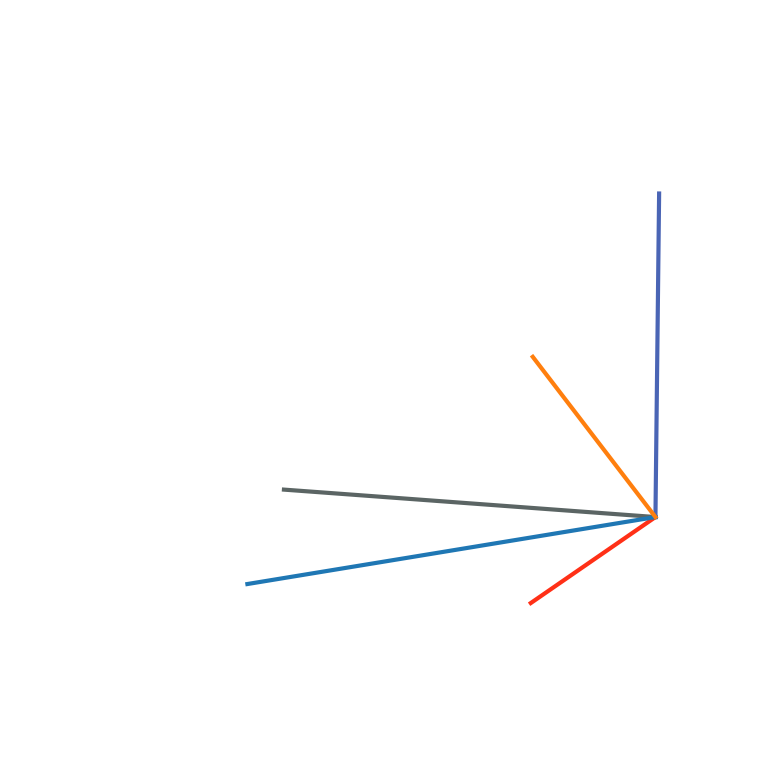

In [18]:
# Figure 3E

ax = plt.figure().add_subplot(projection='3d')

ref = torch.linalg.qr(torch.stack([result_dict["choice"][0], result_dict["I"][0][0], result_dict["I"][1][0]], 1)).Q
ref[:, 2] = ref[:, 2]

choice_ref = (result_dict["choice"][0].view(1, -1) @ ref).squeeze().cpu()
I1_ref = (result_dict["I"][0][0].view(1, -1) @ ref).squeeze().cpu()
I2_ref = (result_dict["I"][1][0].view(1, -1) @ ref).squeeze().cpu()

sv1_ref = (result_dict["sv"][0].view(1, -1) @ ref).squeeze().cpu()
sv2_ref = (result_dict["sv"][1].view(1, -1) @ ref).squeeze().cpu()

def normalize(x):
    return x / x.norm()

I1_ref = normalize(I1_ref)
I2_ref = normalize(I2_ref)

ax.plot(*[(0, choice_ref[r]) for r in range(3)], color="#FF3017")
ax.plot(*[(0, I1_ref[r]) for r in range(3)], color=mod_color[0])
ax.plot(*[(0, I2_ref[r]) for r in range(3)], color=mod_color[1])

ax.plot(*[(0, sv1_ref[r]) for r in range(3)], color=dcolor[0])
ax.plot(*[(0, sv2_ref[r]) for r in range(3)], color=dcolor[1])

ax.view_init(elev=10., azim=20)
ax.set_axis_off()

save_figure("geometry rank 3 pop 3", format="pdf")

In [19]:
cms = list()
for rd in all_result:
    _L = torch.cat([rd["rnn_I"], rd["rnn_V"], rd["rnn_U"]], 1)
    cm = torch.zeros(10, 10)
    for i in range(10):
        for j in range(10):
            cm[i, j] = cosine_similarity(_L[:, i], _L[:, j])
    cms.append(cm)
cm = torch.stack(cms, 0)

In [20]:
cm.std(0).mean() * 10**7

tensor(1.06)

In [21]:
L = torch.cat([result_dict["rnn_I"], result_dict["rnn_V"], result_dict["rnn_U"]], 1)
print(L.shape)
cosangle_matrix = torch.zeros(10, 10)
for i in range(10):
    for j in range(10):
        cosangle_matrix[i, j] = cosine_similarity(L[:, i], L[:, j])

torch.Size([15000, 10])


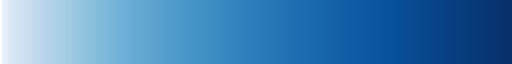

In [22]:
# Define your gamma value
gamma = 3
from matplotlib.colors import LinearSegmentedColormap, to_rgba
# Get the existing Blues colormap
blues_cmap = plt.cm.get_cmap('Blues')
# Extract color information and apply gamma correction
n_colors = 256
colors = blues_cmap(np.linspace(0, 1, n_colors) ** 0.5)
colors = colors
# Insert pure white at the start
colors[0] = to_rgba('white')
# Create a custom colormap
custom_cmap = LinearSegmentedColormap.from_list('custom_blues', colors)
custom_cmap

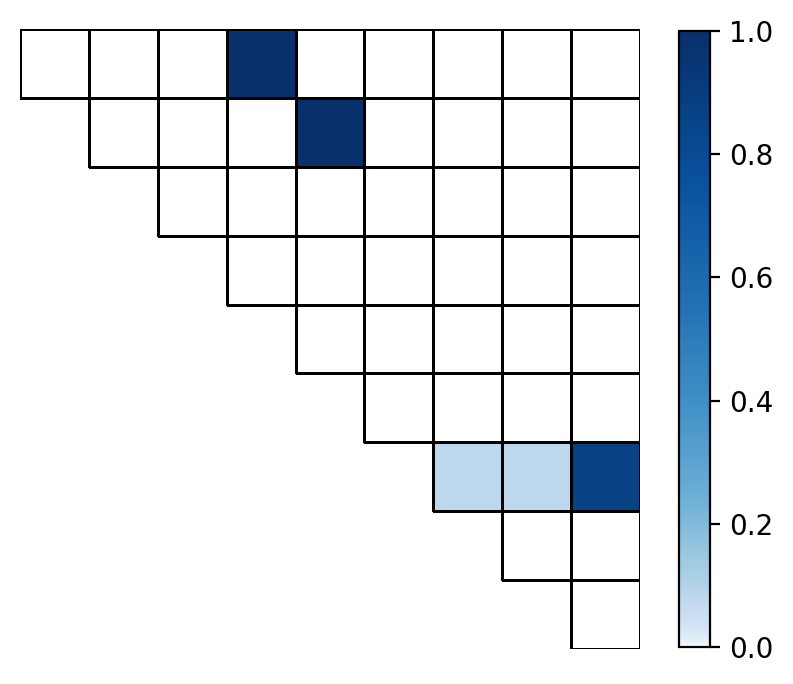

In [23]:
# Figure 3A

fig, ax = plt.subplots(figsize=(5,5))

alpha = torch.zeros(10, 10)
for i in range(10):
    for j in range(10):
        if j > i:
            alpha[i, j] = 1
# Use pcolormesh to plot the matrix
mesh = ax.pcolormesh(cosangle_matrix[:9, 1:].flip(0), cmap=custom_cmap, vmin=0, vmax=1, shading='flat', edgecolors='k', linewidth=0.5)
mesh.set_alpha(alpha[:9, 1:].flip(0).flatten())  # Use set_alpha method to set alpha

ax.set_aspect('equal')
ax.axis("off")

# Add colorbar
fig.colorbar(mesh, ax=ax, shrink=0.8)

save_figure("overlap", format="pdf")

In [24]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)

spike_input, y, cnds, ctx, cnd_ctx = get_standard_spike_input(fixed_t=10)
design_x = torch.ones(72, 5).to(device)
design_x[:, 0] = ctx # context
design_x[:, 1] = y[:, 0, 0] # choice
for b in range(72):
    design_x[b, 2] = [38/40, 30/40, 10/40, -10/40, -30/40, -38/40][cnds[b, 0]]
    design_x[b, 3] = [38/40, 30/40, 10/40, -10/40, -30/40, -38/40][cnds[b, 1]]
design_x

@torch.no_grad()
def calculate_tdr(rnn, repeat:int=100, reg=0)->torch.Tensor:
    N = rnn.x_dim()
    xtx = torch.zeros(5, 5).to(device)
    xty = torch.zeros(5, 51, N).to(device)

    for i in trange(repeat):
        spike_input, y, cnds, ctx, cnd_ctx = get_standard_spike_input(fixed_t=10)
        h = rnn(spike_input, noise_inp=0, noise_rec=0)
        f = rnn.phi(h)
        xtx += design_x.T @ design_x
        xty += torch.einsum("br,btn->rtn", design_x, f)
    return torch.einsum("ir,rtn->itn", torch.inverse(xtx + reg * torch.eye(design_x.shape[-1]).type_as(xtx)), xty)

In [25]:
def positive_qr(x):
    Q, R = torch.linalg.qr(x)
    for i in range(R.shape[0]):
        if R[i, i] < 0:
            R[i, :] = -R[i, :]
            Q[:, i] = -Q[:, i]
    return Q, R

beta_time = calculate_tdr(rnn)
beta = torch.zeros(5, beta_time.shape[-1]).to(device)
for b in range(5):
    time_index = beta_time[b].norm(dim=1).max(dim=0).indices.item()
    beta[b, :] = beta_time[b, time_index, :]
beta = positive_qr(beta.T)[0]

100%|██████████| 100/100 [00:03<00:00, 25.37it/s]


In [26]:
f = 0
n_repeat = 500
with torch.no_grad():
    for r in trange(n_repeat):
        spike_input, y, cnds, ctx, cnd_ctx = get_standard_spike_input(fixed_t=10)
        h = rnn(spike_input, noise_inp=0, noise_rec=0)
        f = f + rnn.phi(h)
f = f / n_repeat

100%|██████████| 500/500 [00:19<00:00, 25.44it/s]


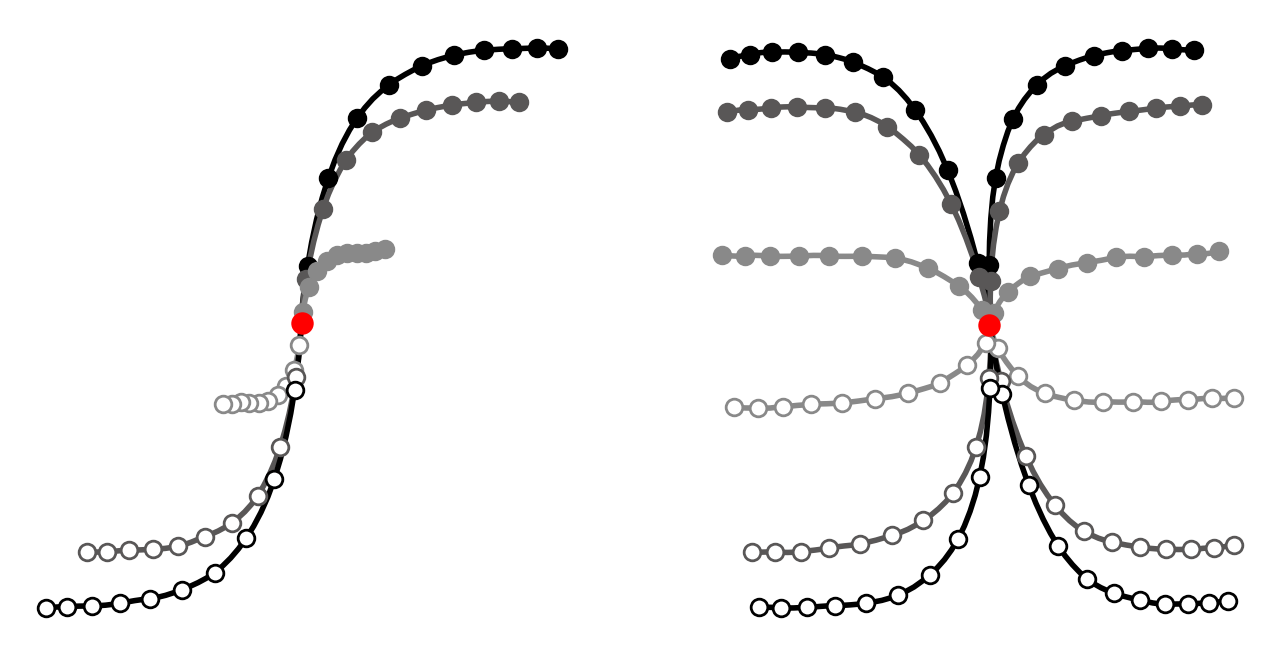

In [27]:
# Figure 3F

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

tad = (f @ beta)

ax = axs[0]

ts = vector.range(4, 41, 4)

y = tad.reshape(2, 6, 6, 51, 5)[0].mean(1)
for b in range(6):
    yt = y[b, 10:, :]
    color = ["#000000", "#595757", "#898989", "#898989", "#595757", "#000000"][b]
    ax.plot(tn(yt[:, 1]), tn(yt[:, 2]), color=color, lw=2)
    ax.scatter(tn(yt[ts, 1]), tn(yt[ts, 2]), edgecolor=color, facecolor=[color, "w"][b>=3], zorder=10)
ax.axis("off")  
ax.scatter([0], [0], s=50, color="r", zorder=100)
    
ax = axs[1]

y = tad.reshape(2, 6, 6, 51, 5)[1]
for b in range(6):
    color = ["#000000", "#595757", "#898989", "#898989", "#595757", "#000000"][b]
    yt = y[b, :3, 10:, :].mean(0)
    ax.plot(tn(yt[:, 1]), tn(yt[:, 2]), color=color, lw=2)
    ax.scatter(tn(yt[ts, 1]), tn(yt[ts, 2]), edgecolor=color, facecolor=[color, "w"][b>=3], zorder=10)
    yt = y[b, 3:, 10:, :].mean(0)
    ax.plot(tn(yt[:, 1]), tn(yt[:, 2]), color=color, lw=2)
    ax.scatter(tn(yt[ts, 1]), tn(yt[ts, 2]), edgecolor=color, facecolor=[color, "w"][b>=3], zorder=10)
ax.axis("off")

ax.scatter([0], [0], s=50, color="r", zorder=100)

save_figure("trial_averaged_dynamics", format="pdf")

In [28]:
ec_mn = []
ec_In = []

for result_dict in all_result:
    gain = torch.stack(result_dict["gain"], 0)
    m_rep = torch.einsum("ci,ir->cir", gain, result_dict["rnn_U"])
    I_rep = torch.einsum("ci,ir->cir", gain, result_dict["rnn_I"])

    ec_mn.append(torch.einsum("cif,it->cft", m_rep, result_dict["rnn_V"]) / rnn.x_dim())
    ec_In.append(torch.einsum("cif,it->cft", I_rep, result_dict["rnn_V"]) / rnn.x_dim())
    
ec_mn = torch.stack(ec_mn, 0)
ec_In = torch.stack(ec_In, 0)

In [29]:
print(ec_mn.shape, ec_In.shape)

torch.Size([100, 2, 3, 3]) torch.Size([100, 2, 4, 3])


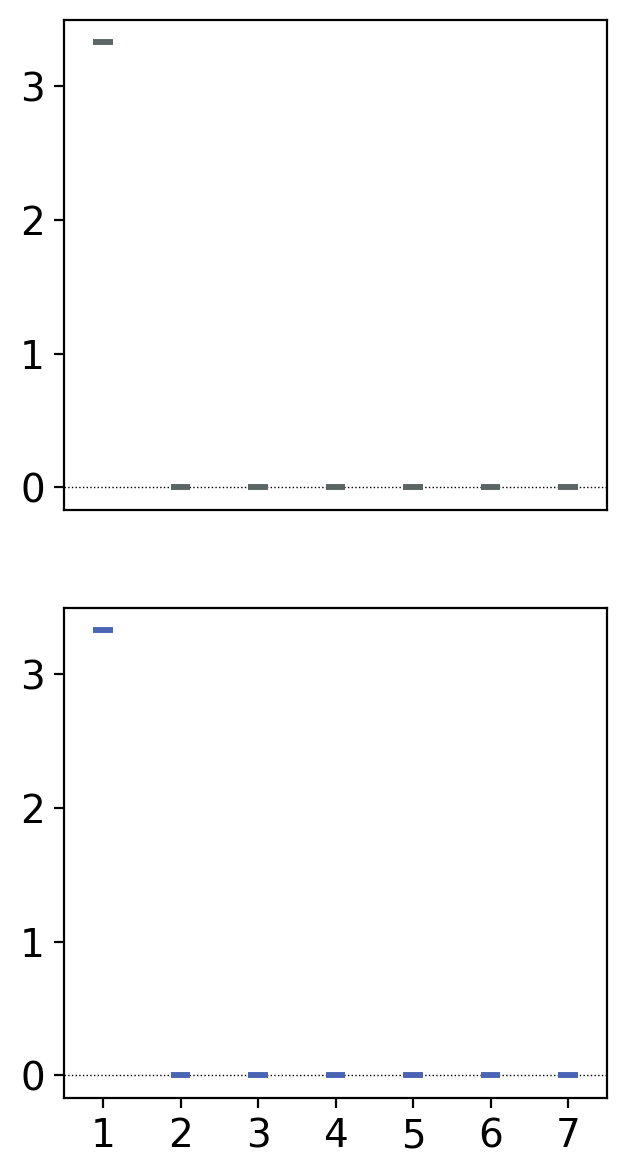

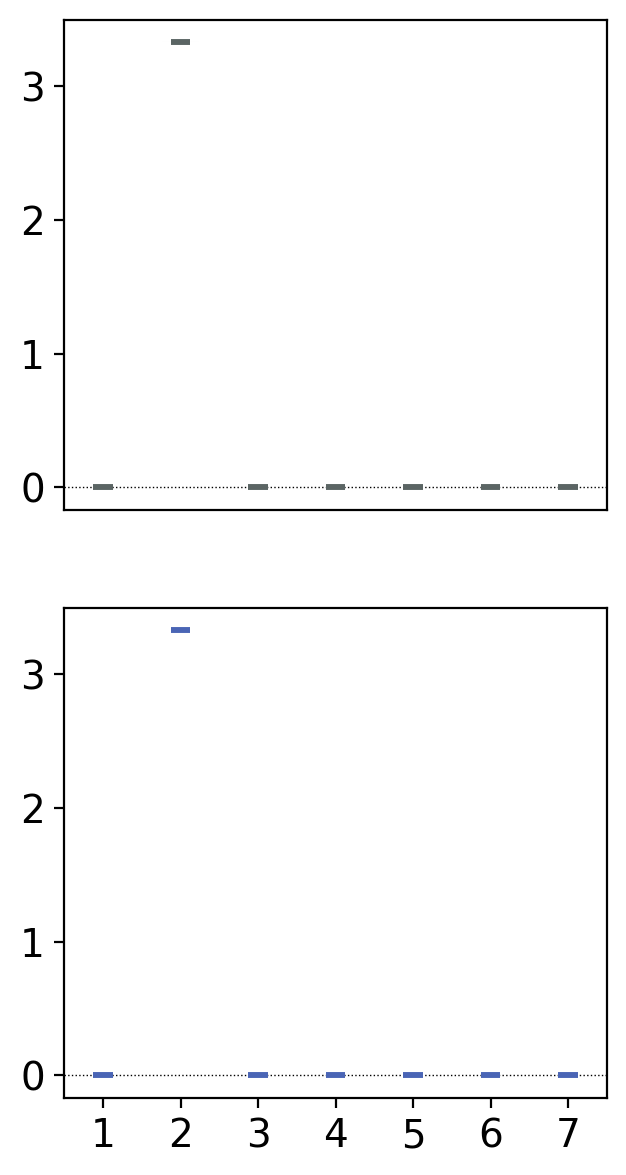

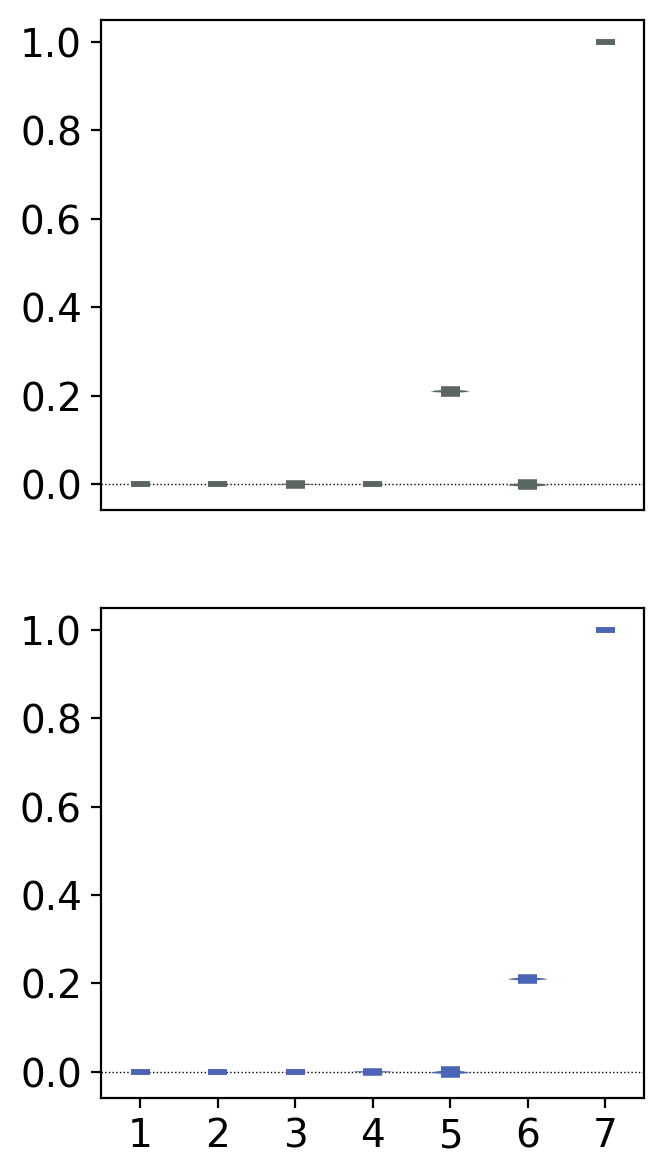

In [30]:
# Figure 4-figure supplement 1

for nr in range(3):

    fig, axs = plt.subplots(2, 1, figsize=(3.5, 7))

    for context in range(2):
        ax = axs[context]
        data = [*[tn(ec_In[:, context, r, nr]) for r in range(4)], *[tn(ec_mn[:, context, r, nr]) for r in range(3)]]

        # Vertical violin plot
        parts = ax.violinplot(data, vert=True)

        for i, pc in enumerate(parts['bodies']):
            pc.set_facecolor(mod_color[context])
            pc.set_edgecolor('none')
            pc.set_alpha(1)    

        ax.plot([0.5, 7.5], [0, 0], "k:", zorder=-1, lw=0.5)
        ax.set_xlim(0.5, 7.5)
#         ax.set_ylim(-0.2, 1.3)

        # Set line color to black
        for key in ['cmeans', 'cmins', 'cmaxes', 'cbars']:
            if key in parts:
                parts[key].set_edgecolor(mod_color[context])
                parts[key].set_linewidth(2.)  # Set line width thicker if needed

        ax.tick_params(axis="x", labelsize=14)
        ax.tick_params(axis="y", labelsize=14)

        if context == 0:
            ax.set_xticks([])
        else:
            ax.set_xticks([1, 2, 3, 4, 5, 6, 7])
#         ax.set_yticks([0, 0.5, 1.0])

    save_figure(f"effective_coupling {['iv1', 'iv2', 'dv'][nr]}", format="pdf")

In [31]:
def effective_coupling(x, y):
    if x.dim() == 1 and y.dim() == 1:
        return (x * y).sum() / x.shape[0]
    return (x.T @ y) / x.shape[0]

tensor([[     0.00,      0.00,      0.21],
        [     0.00,      0.00,     -0.00],
        [     0.00,      0.00,      1.00]], device='cuda:5') tensor([[     3.33,      0.00,      0.00],
        [     0.00,      3.33,      0.00],
        [     0.00,      0.00,      0.00],
        [     0.00,      0.00,     -0.00]], device='cuda:5')


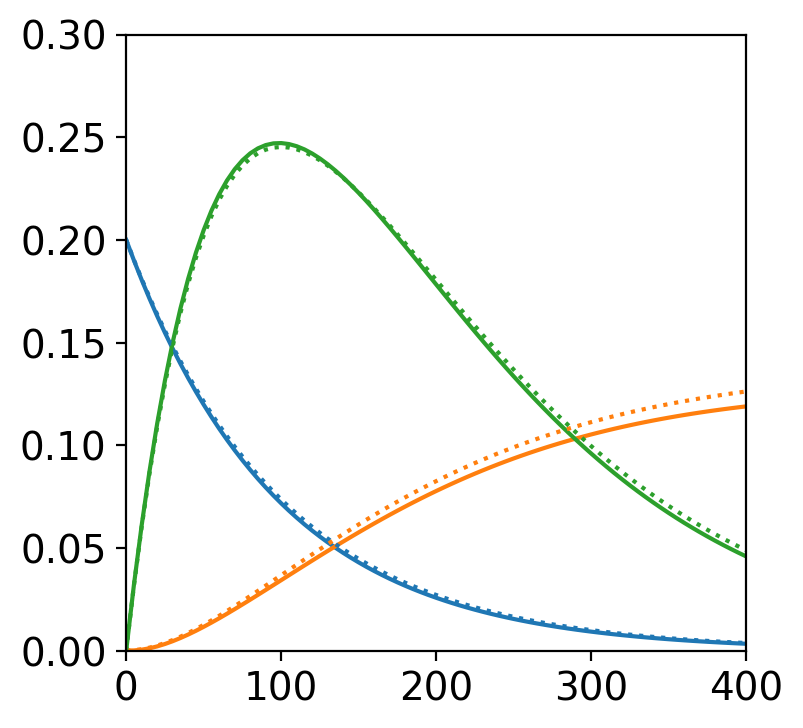

In [32]:
# Figure 4E

torch.manual_seed(0)
rnn.hyper.delta_t=5
rnn.property.alpha=rnn.hyper.delta_t/rnn.hyper.tau
context = 0
rnn_I = rnn._I.reshape(-1, 4)
rnn_U = rnn._U.reshape(-1, 3)
rnn_V = rnn._V.reshape(-1, 3)
x_star = rnn_I[:, 2]
gain = (1 - torch.tanh(x_star).pow(2))
_m_rep = torch.einsum("n,nr->nr", gain, rnn_U)
_I_rep = torch.einsum("n,nr->nr", gain, rnn_I)
_ec_mn = effective_coupling(_m_rep, rnn_V)
_ec_In = effective_coupling(_I_rep, rnn_V)
print(_ec_mn, _ec_In)
n_step = int(400 / rnn.hyper.delta_t)
input_tensor = torch.zeros(1, 1+n_step, 4).to(device)
input_tensor[:, :, 2] = 1
input_tensor[:, 0, 0] = 4

with torch.no_grad():
    x = rnn(input_tensor, init_state=x_star.unsqueeze(0), noise_rec=0)
delta_x = x[0, 1:, :] - x[0, 0, :]
LOAD = torch.cat([rnn_I, rnn_U], 1)
y = delta_x @ LOAD @ torch.inverse(LOAD.T @ LOAD + torch.eye(7).to(device) * 1e-6)

time = torch.linspace(0, n_step, n_step+1).to(device) * rnn.hyper.delta_t / 1000
theory_kinp = (torch.exp(-time/0.1)) * rnn.property.alpha * input_tensor[:, 0, 0]
theory_kiv = (time/0.1*torch.exp(-time/0.1)) * rnn.property.alpha * _ec_In[0, 0] * input_tensor[:, 0, 0]
theory_kdv = (1-torch.exp(-time/0.1) * (1+time/0.1)) * rnn.property.alpha * _ec_In[0, 0] * _ec_mn[0, 2] * input_tensor[:, 0, 0]

fig, ax = plt.subplots(figsize=(4, 4))

ax.plot(tn(time) * 1000, tn(y[:, 0]), color=dcolor[0])
ax.plot(tn(time) * 1000, tn(y[:, -1]), color=dcolor[1])
ax.plot(tn(time) * 1000, tn(y[:, -3]), color=dcolor[2])

ax.plot(tn(time) * 1000, tn(theory_kinp), ":", color=dcolor[0])
ax.plot(tn(time) * 1000, tn(theory_kdv), ":", color=dcolor[1])
ax.plot(tn(time) * 1000, tn(theory_kiv), ":", color=dcolor[2])

ax.set_ylim(0, 0.3)
ax.set_xlim(0, 400)

ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)

save_figure("task variable simulated vs predicted", format="pdf")

In [33]:
L = torch.cat([rnn._I, rnn._U, rnn._V], 2)
print(L.shape)

torch.Size([3, 5000, 10])


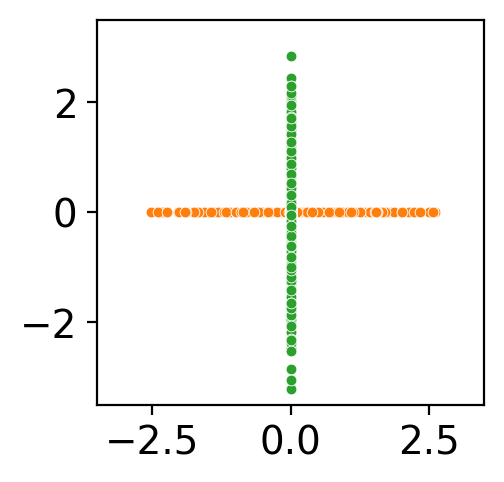

In [34]:
L = rnn._I[:, :, 2:]

w = [3.5, 3.5, 3.5, 3.5, 3.5, 35, 35, 10]
nL = L.shape[-1]

fig, ax = plt.subplots(figsize=(2.5,2.5))

for p in range(3):
    ax.scatter(tn(L[p, :500, 0]), tn(L[p, :500, 1]), s=15, edgecolor="w", lw=0.3)
ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)
# plt.tight_layout()

ax.set_xlim(-3.5, 3.5)
ax.set_ylim(-3.5, 3.5)

save_figure("loading space ctx", format="pdf")

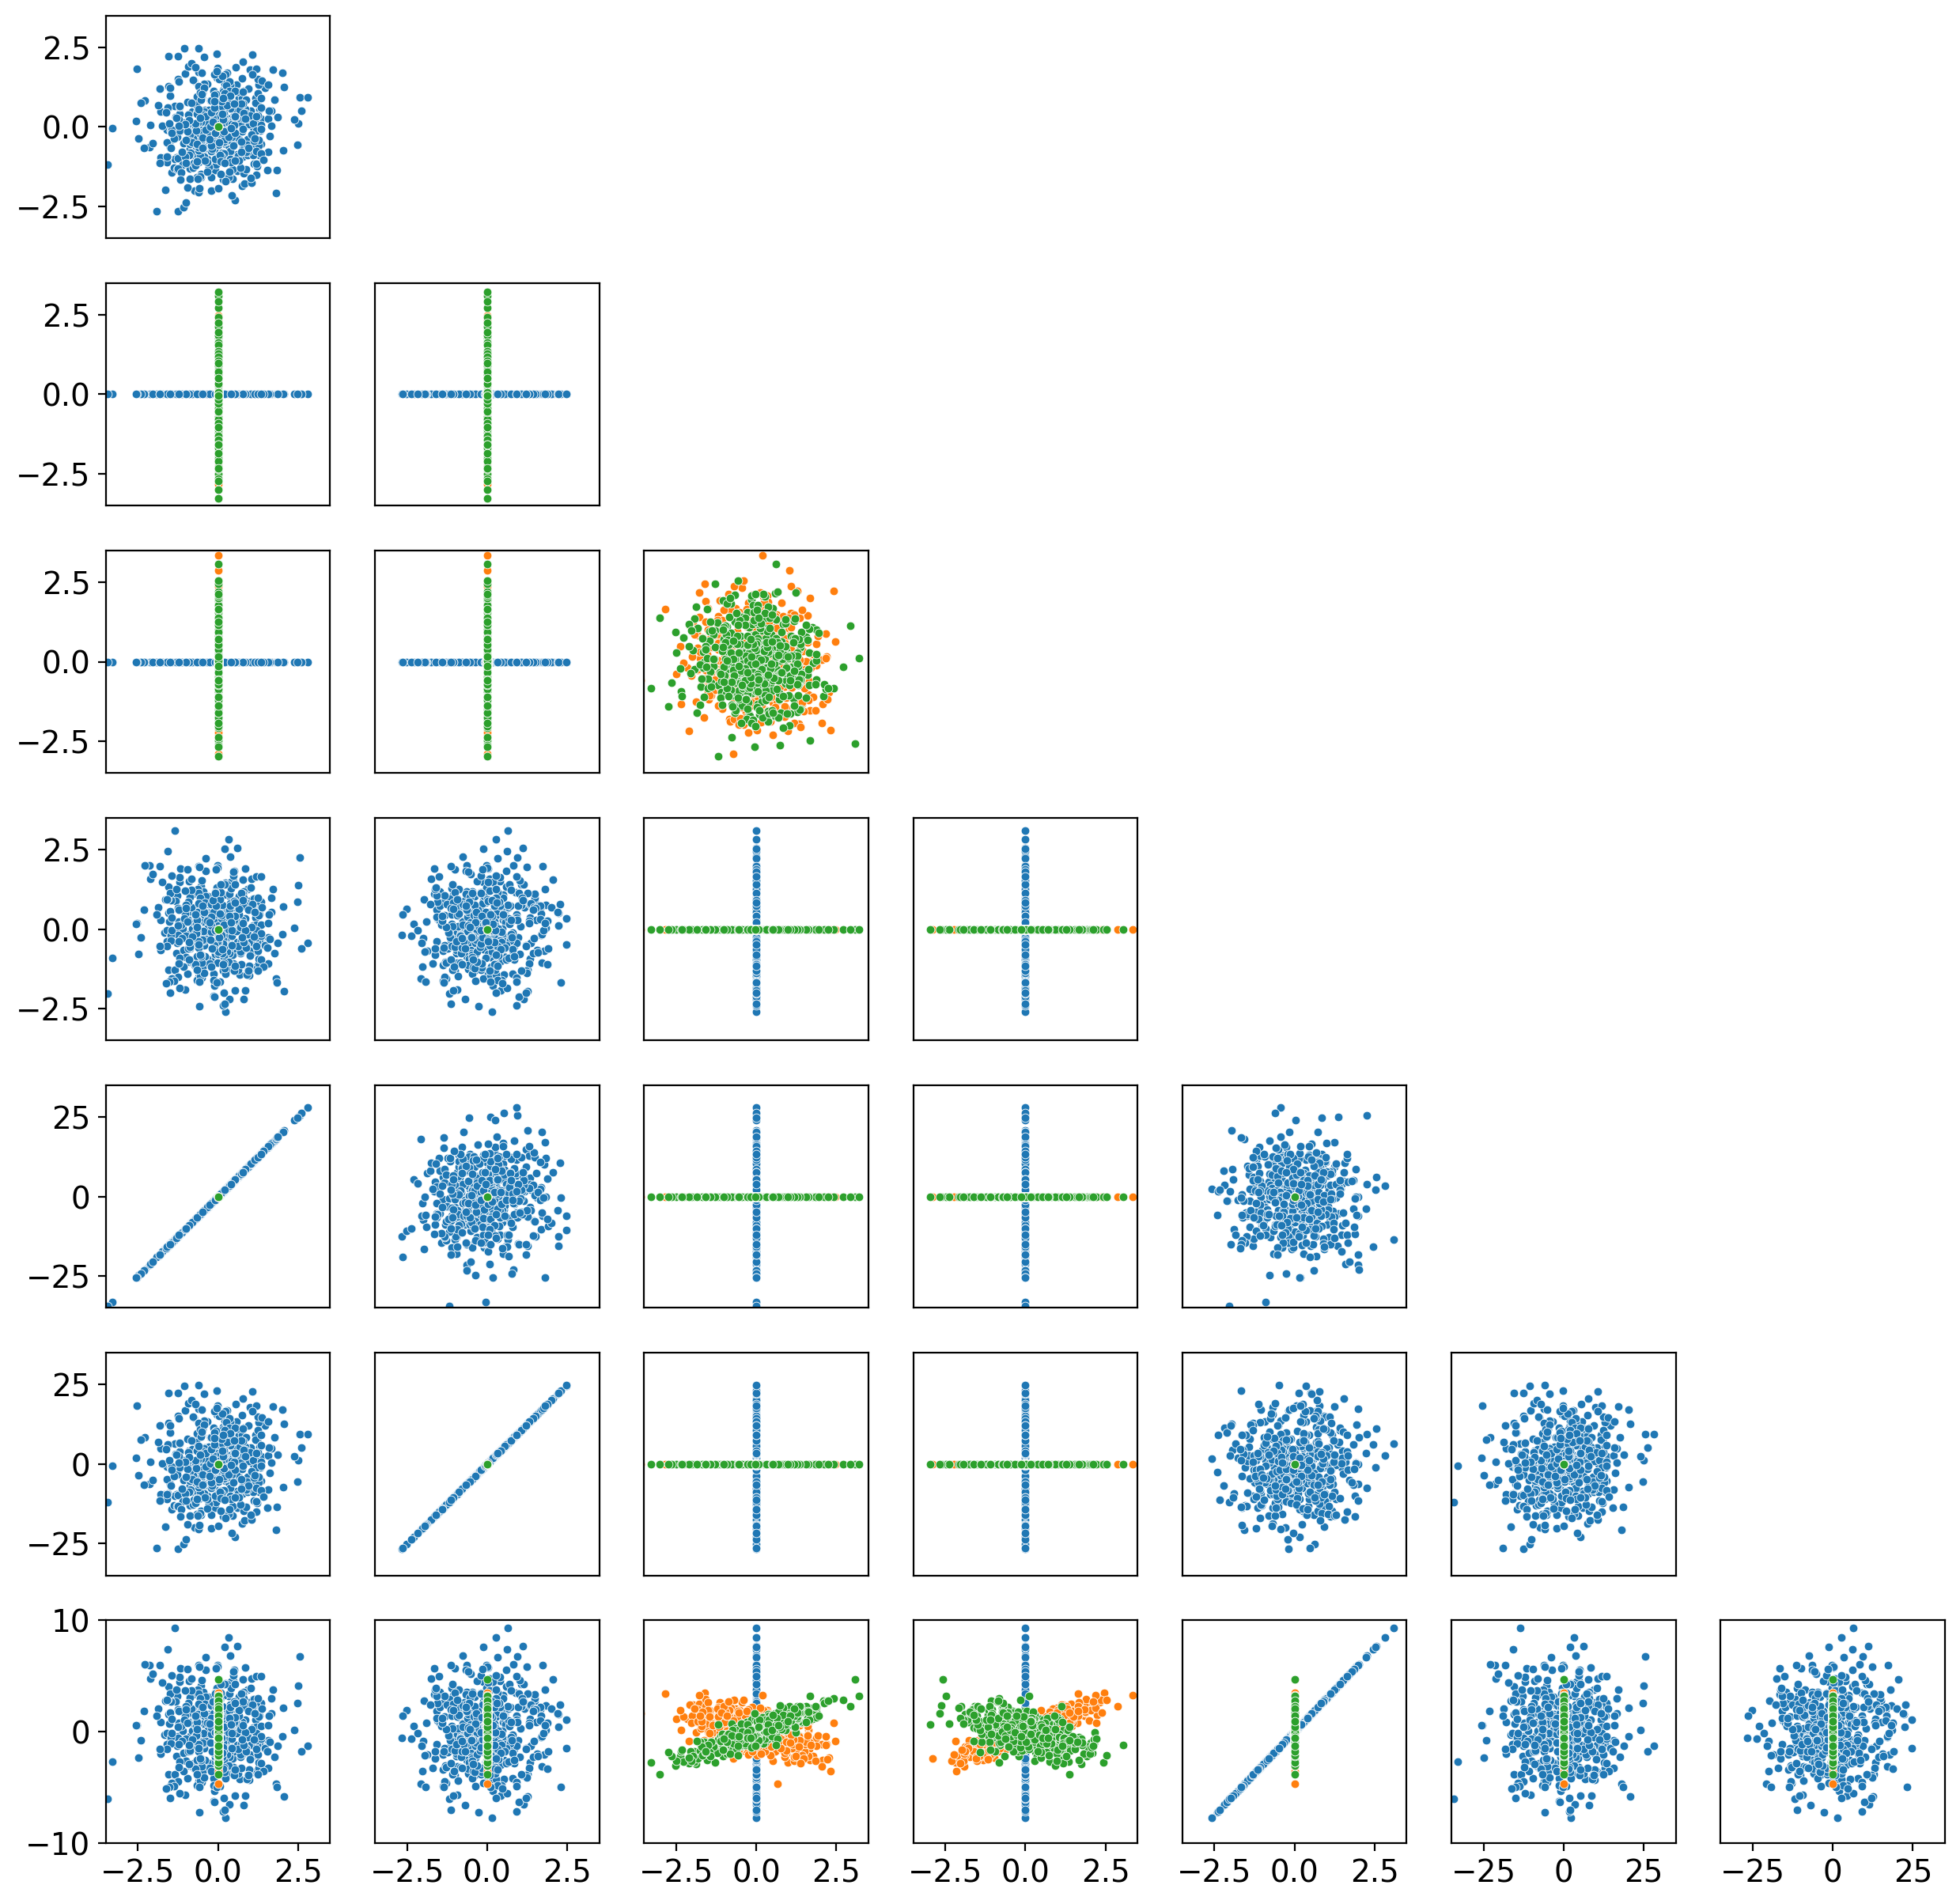

In [35]:
# Figure 3-figure supplement 1

L = torch.cat([rnn._I[:, :, :2], rnn._U, rnn._V], 2)

w = [3.5, 3.5, 3.5, 3.5, 3.5, 35, 35, 10]
nL = L.shape[-1]

fig, axs = plt.subplots(nL-1, nL-1, figsize=(3*5, 3*5))
for i in range(nL-1):
    for j in range(nL-1):
        ax = axs[i, j]
        if i < j:
            ax.axis("off")
            continue
        else:
            for p in range(3):
                ax.scatter(tn(L[p, :500, j]), tn(L[p, :500, i+1]), s=15, edgecolor="w", lw=0.3)
            ax.tick_params(axis="x", labelsize=14)
            ax.tick_params(axis="y", labelsize=14)
            if j > 0: ax.set_yticks([])
            if i!=nL-2: ax.set_xticks([])
            ax.set_xlim(-w[j], w[j])
            ax.set_ylim(-w[i+1], w[i+1])
# plt.tight_layout()

save_figure("loading space", format="pdf")